<a href="https://colab.research.google.com/github/Vipulmishra1/Financial-Transactions-Customer-Analysis/blob/main/Financial_Transactions_%26_Customer_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 Project Title: Financial Transactions & Customer Analysis Using SQL

Objective:
To simulate a mini banking system with customers and transactions, and use SQL queries + JOINs to gain business insights such as:


*   Spending Behavior
*   Account Activity
*   Transaction types
*   Inactive Customers
*   Negative Balances







In [57]:
import sqlite3
import pandas as pd


Step 1: Create In-Memory Database

In [65]:
conn = sqlite3.connect(":memory:")
cursor = conn.cursor()


**What we're doing:**

We create a temporary SQLite database that runs entirely in memory, perfect for quick prototyping and small projects like this one.

Step 2: Create Tables

a) Customers Table

In [66]:
cursor.execute("""
CREATE TABLE Customers (
    Customer_ID INTEGER PRIMARY KEY,
    Name TEXT,
    Account_Type TEXT,
    City TEXT,
    Join_Date DATE
);
""")


b) Transactions Table

In [67]:
cursor.execute("""
CREATE TABLE Transactions (
    Transaction_ID INTEGER PRIMARY KEY,
    Customer_ID INTEGER,
    Amount REAL,
    Type TEXT CHECK(Type IN ('Credit', 'Debit')),
    Transaction_Date DATE,
    FOREIGN KEY(Customer_ID) REFERENCES Customers(Customer_ID)
);
""")


We're setting up two tables:

Customers: Who the people are

Transactions: What they did financially
And linking them using a foreign key for relational analysis.



Step 3: Insert Sample Data
Add Customers

In [69]:
customers_data = [
    (1, 'Alice', 'Savings', 'New York', '2022-01-15'),
    (2, 'Bob', 'Checking', 'Chicago', '2022-03-10'),
    (3, 'Charlie', 'Savings', 'Los Angeles', '2022-05-20'),
    (4, 'Diana', 'Checking', 'New York', '2022-06-25'),
    (5, 'Eve', 'Savings', 'Chicago', '2022-08-19'),
    (6, 'Frank', 'Savings', 'Boston', '2022-10-01'),
]
cursor.executemany("INSERT INTO Customers VALUES (?, ?, ?, ?, ?);", customers_data)


Add Transactions

In [70]:
transactions_data = [
    (1, 1, 500.00, 'Credit', '2022-01-20'),
    (2, 1, 200.00, 'Debit', '2022-02-01'),
    (3, 2, 1000.00, 'Credit', '2022-03-12'),
    (4, 2, 400.00, 'Debit', '2022-03-15'),
    (5, 2, 150.00, 'Debit', '2022-04-01'),
    (6, 3, 700.00, 'Credit', '2022-05-22'),
    (7, 3, 300.00, 'Debit', '2022-06-01'),
    (8, 4, 1200.00, 'Credit', '2022-07-01'),
    (9, 4, 600.00, 'Debit', '2022-07-05'),
    (10, 5, 500.00, 'Credit', '2022-08-21'),
    (11, 5, 100.00, 'Debit', '2022-08-25'),
    (12, 1, 100.00, 'Debit', '2022-02-15'),
    (13, 3, 100.00, 'Debit', '2022-06-15'),
    (14, 2, 300.00, 'Credit', '2022-04-15'),
    (15, 5, 50.00, 'Debit', '2022-09-01'),
]
cursor.executemany("INSERT INTO Transactions VALUES (?, ?, ?, ?, ?);", transactions_data)
conn.commit()


What we're doing:
We're adding 6 customers and 15 transactions, mixing Credits (money added) and Debits (money spent) across multiple accounts.

Step 4: SQL Analysis

Query 1: Total Amount Spent by Each Customer

In [71]:
query1 = """
SELECT C.Name, SUM(T.Amount) AS Total_Spent
FROM Customers C
JOIN Transactions T ON C.Customer_ID = T.Customer_ID
WHERE T.Type = 'Debit'
GROUP BY C.Name
ORDER BY Total_Spent DESC;
"""
pd.read_sql_query(query1, conn)


,Name,Total_Spent
0,Diana,600.0
1,Bob,550.0
2,Charlie,400.0
3,Alice,300.0
4,Eve,150.0


**What we’re doing:**

Joining both tables and calculating total Debit transactions per customer to find who spends the most.

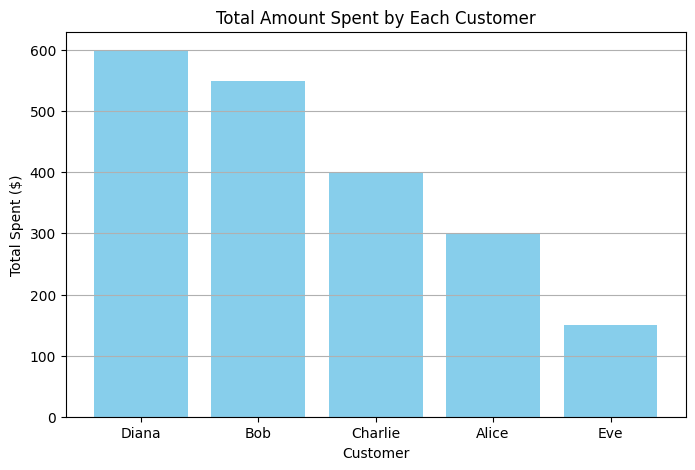

In [72]:
import matplotlib.pyplot as plt

df1 = pd.read_sql_query(query1, conn)
plt.figure(figsize=(8,5))
plt.bar(df1['Name'], df1['Total_Spent'], color='skyblue')
plt.title("Total Amount Spent by Each Customer")
plt.xlabel("Customer")
plt.ylabel("Total Spent ($)")
plt.grid(axis='y')
plt.show()


Query 2: Most Common Transaction Type
We analyze how often each transaction type (Credit vs Debit) occurs.

Insight: Shows if customers are depositing or spending more.

In [73]:
query2 = """
SELECT Type, COUNT(*) AS Frequency
FROM Transactions
GROUP BY Type
ORDER BY Frequency DESC;
"""
pd.read_sql_query(query2, conn)


,Type,Frequency
0,Debit,9
1,Credit,6


What we’re doing:
Finding which transaction type — Credit or Debit — happens the most. Useful for understanding customer behavior.

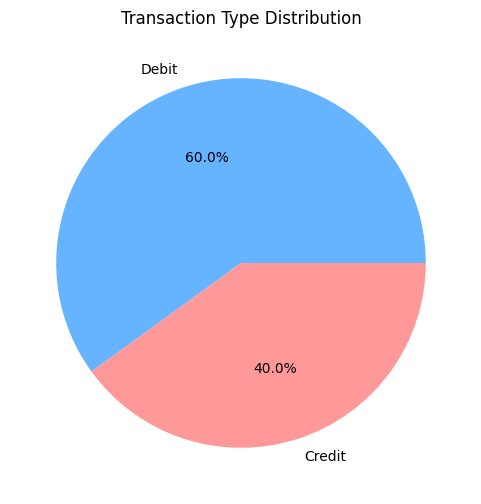

In [74]:
df2 = pd.read_sql_query(query2, conn)
plt.figure(figsize=(6,6))
plt.pie(df2['Frequency'], labels=df2['Type'], autopct='%1.1f%%', colors=['#66b3ff','#ff9999'])
plt.title("Transaction Type Distribution")
plt.show()


Query 3: Highest Spender by Account Type
We analyze spending patterns grouped by account type using JOIN and GROUP BY.

Insight: Helps banks understand which account types generate more activity.

In [75]:
query3 = """
SELECT C.Account_Type, SUM(T.Amount) AS Total_Spent
FROM Customers C
JOIN Transactions T ON C.Customer_ID = T.Customer_ID
WHERE T.Type = 'Debit'
GROUP BY C.Account_Type;
"""
pd.read_sql_query(query3, conn)


,Account_Type,Total_Spent
0,Checking,1150.0
1,Savings,850.0


What we’re doing:

Analyzing how much money is spent by each account type (Savings vs Checking). This helps us understand where transaction volume comes from.

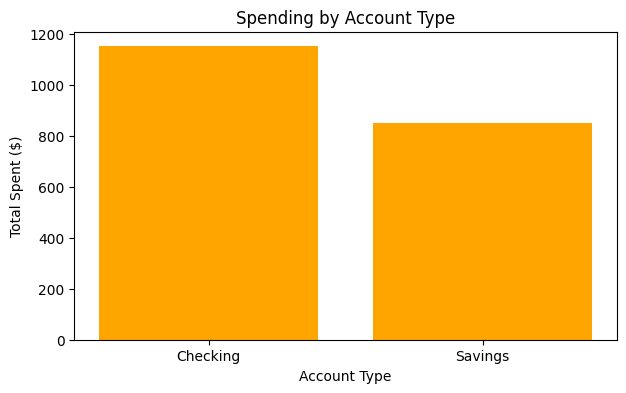

In [76]:
df3 = pd.read_sql_query(query3, conn)
plt.figure(figsize=(7,4))
plt.bar(df3['Account_Type'], df3['Total_Spent'], color='orange')
plt.title("Spending by Account Type")
plt.xlabel("Account Type")
plt.ylabel("Total Spent ($)")
plt.show()


Customers with No Transactions
We use a LEFT JOIN to find customers who have never made a transaction.

Insight: Useful for targeting inactive customers with promotional offers.



In [77]:
query4 = """
SELECT C.Name
FROM Customers C
LEFT JOIN Transactions T ON C.Customer_ID = T.Customer_ID
WHERE T.Transaction_ID IS NULL;
"""
pd.read_sql_query(query4, conn)


,Name
0,Frank


What we’re doing:
Using a LEFT JOIN to find customers who exist but have no transactions. These might be inactive users — great targets for re-engagement

Query 5: Customers with Negative Balance
We calculate net balance (credits - debits) per customer and find those with negative values.

Insight: Flags customers who may need attention or credit risk assessment.

In [78]:
query5 = """
SELECT C.Name,
       SUM(CASE WHEN T.Type = 'Credit' THEN T.Amount ELSE 0 END) AS Total_Credit,
       SUM(CASE WHEN T.Type = 'Debit' THEN T.Amount ELSE 0 END) AS Total_Debit,
       SUM(CASE WHEN T.Type = 'Credit' THEN T.Amount ELSE 0 END) -
       SUM(CASE WHEN T.Type = 'Debit' THEN T.Amount ELSE 0 END) AS Balance
FROM Customers C
JOIN Transactions T ON C.Customer_ID = T.Customer_ID
GROUP BY C.Name
HAVING Balance < 0;
"""
pd.read_sql_query(query5, conn)


,Name,Total_Credit,Total_Debit,Balance


What we’re doing:
We calculate net balance = credits - debits for each customer, and then filter only those with negative balances, indicating potential overdraft issues or risk.



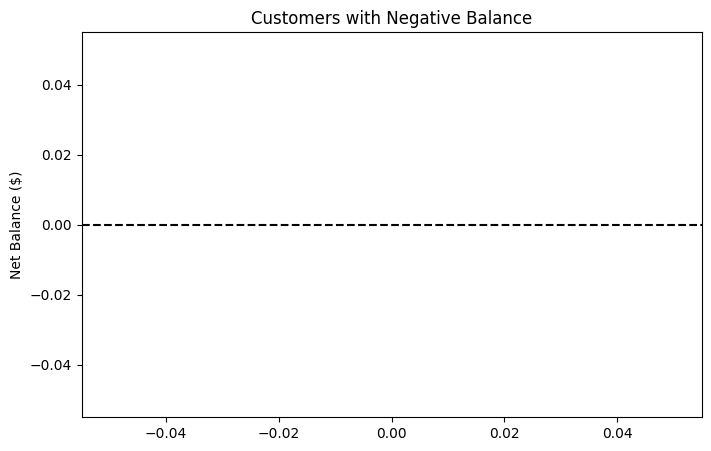

In [79]:
df5 = pd.read_sql_query(query5, conn)
plt.figure(figsize=(8,5))
plt.bar(df5['Name'], df5['Balance'], color='red')
plt.title("Customers with Negative Balance")
plt.ylabel("Net Balance ($)")
plt.axhline(0, color='black', linestyle='--')
plt.show()


📈 Final Thoughts:
This project simulates how financial institutions use SQL and relational databases to:

Monitor spending patterns

Understand customer behavior

Identify inactive or at-risk users

Segment customers by product or account type

It’s a great starting point for real-world financial analyst roles.

Financial Analysts

Banking operations

Customer Relationship Management